# Read and Prepare Data

In [1]:
import math
import re
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
# Reading from txt file and saving it into rows variable as a list of rows
fdir = "fssp-data-3instances.txt"
f = open(fdir,"r")
text = f.read()
f.close()
rows = text.split("\n")

# Finding beginning and ending rows of related sections of problems
instrows = map(lambda x: re.search("instance", x) !=  None, rows[1:])
instbegin = np.where(list(instrows))[0]

# Trimming problem data and omitting empty rows
ProblemText = list((rows[instbegin[0]:instbegin[1]], rows[instbegin[1]:instbegin[2]], rows[instbegin[2]:]))
for prob in range(3):
    ProblemText[prob] = [r.strip() for r in ProblemText[prob]  if r.strip() != "" ]

# Algorithm Classes 

In [ ]:
def dist(x,y = 0):
    return np.sqrt( np.sum((x - y)**2) )

In [3]:
class Problem():
    # Attributes: name, zstar, njob, nmachine, costmatrix
    def __init__(self, prdata):
        row0 = prdata[0].split(" ")
        row0 = [w for w in row0 if w != ""]
        self.name = row0[1]
        self.zstar = int(row0[3][:-1])
        
        row1 = prdata[1].split(" ")
        row1 = [w for w in row1 if w != ""]
        self.njob = int(row1[0])
        self.nmachine = int(row1[1])
        
        rowOthers = prdata[2:]
        matList = list()
        for r in rowOthers:
            rowList = list()
            for w in r.split(" "):
                if w.isnumeric(): rowList.append(int(w))
            matList.append(rowList)
        matList2 = [ [ r[i] for i in range(1,len(r),2)] for r in matList]
        self.costmatrix = np.stack(matList2).reshape(self.njob, self.nmachine)
        
    def __repr__(self):
        rep = f"{self.name} FSSP with {self.njob} jobs {self.nmachine} machines"
        return rep
    
    def __str__(self):
        return self.__repr__()

In [4]:
class Sol():
    # Attributes: x, RandKey
    # Members: F(), UpdateRandKey(), UpdateX(), Mutate()
    def __init__(self, njobs, jobs = [], rkey = False):
        jobs = list(jobs)
        if rkey == True: # If solution is created using random key vector
            if jobs != []:
                # Check Duplicates
                jobs = np.array(jobs)
                counts = [(jobs == val).sum() for val in jobs]
                idxDupl = np.where(np.array(counts) > 1)[0]; lDupl = len(idxDupl)
                if lDupl:
                    jobs[idxDupl] += np.random.choice(range(lDupl),lDupl,replace=False)*1.e-6
                jobs = list(jobs)
            if len(jobs) > njobs:
                self.RandKey = np.random.choice(jobs,njobs,replace=False)
                print("List length exceeds njobs. Randomly selected")
            elif len(jobs) == njobs: self.RandKey = jobs
            else:
                missing = njobs - len(jobs)
                newR = np.random.random(missing)
                self.RandKey = jobs + [newR]
            self.UpdateX()
            
        else: # If permutation solution will be created first
            if jobs != []:
                adjJobs = [np.where(np.sort(jobs) == j )[0][0] for j in jobs]
                jobs = list(adjJobs) # Input vector is adjusted
            
            if len(jobs) > njobs:
                self.x = np.random.choice(jobs,njobs,replace=False)
                print("List length exceeds njobs. Randomly selected")
            elif len(jobs) == njobs: self.x = jobs
            else:
                jobsNotSelected = [j for j in list(range(njobs)) if j not in jobs]
                randomJobs = np.random.choice(jobsNotSelected,njobs - len(jobs) ,replace=False)
                self.x = jobs + list(randomJobs)
            self.UpdateRandKey()
         
    def F(self, Prob): # Fitness (Cost) Function: Calculates Makespan
        tBegin = np.matrix((Prob.njob*Prob.nmachine)*[0]).reshape(Prob.njob,Prob.nmachine)
        tEnd = np.matrix((Prob.njob*Prob.nmachine)*[float('inf')]).reshape(Prob.njob,Prob.nmachine)
        
        tBegin[0,0] = 0; tEnd[0,0] = Prob.costmatrix[self.x[0],0]
        for orderJ in range(1,Prob.njob):
            tBegin[orderJ,0] = tEnd[orderJ-1,0]
            tEnd[orderJ,0] = tBegin[orderJ,0] + Prob.costmatrix[self.x[orderJ],0] 
        
        for m in range(1,Prob.nmachine):
            tBegin[0,m] = tEnd[0,m-1]
            tEnd[0,m] = tBegin[0,m] + Prob.costmatrix[self.x[0],m]
            for orderJ in range(1,Prob.njob):
                tBegin[orderJ,m] = max(tEnd[orderJ,m-1], tEnd[orderJ-1,m])
                tEnd[orderJ,m] = tBegin[orderJ,m] + Prob.costmatrix[self.x[orderJ],m]
        
        return tEnd[-1,-1]
    
    def UpdateRandKey(self): # To create random key from permutation representation
        n = len(self.x)
        Rvector = np.random.random(n)
        Rvector = list(np.sort(Rvector))
        RandKey = Rvector.copy()
        for i in range(n):
            RandKey[self.x[i]] = Rvector[i]
        
        # Check Duplicates
        RandKey = np.array(RandKey)
        counts = [(RandKey == val).sum() for val in RandKey]
        idxDupl = np.where(np.array(counts) > 1)[0]; lDupl = len(idxDupl)
        if lDupl:
            RandKey[idxDupl] += np.random.choice(range(lDupl),lDupl,replace=False)*1.e-6
        RandKey = list(RandKey)
        
        self.RandKey = list(RandKey)
        
    def UpdateX(self): # To create permutation representation from random key
        Rvector = list(np.sort(self.RandKey))
        newX = [np.where(self.RandKey == R )[0][0] for R in Rvector]
        self.x = newX
    
    def Mutate(self): # Mutate solution and return mutated solution object
        n = len(self.x)
        swap = np.random.choice(n,2, replace = False)
        idx = list(range(n))
        idx[swap[0]] = swap[1]
        idx[swap[1]] = swap[0]
        newRandKeys = list(np.array(self.RandKey)[idx])
        return Sol(n, newRandKeys, rkey = True)
    
    def __repr__(self):
        rep = f"Solution: {self.x}"
        return rep

    def __str__(self):
        return self.__repr__()

In [5]:
class Pairs(): # Pairs of solutions to use for crossover
    # Attributes: M, Sols
    # Members: XO(), Mutation()
    def __init__(self, Sols ):
        self.Sols = Sols
        self.M  = int(len(Sols)/2)
        
    def XO(self): # Crossover y_(2i) and y_(2i+1) i = 0,1,...,M-1
        children = list()
        n = len(self.Sols[0].x)
        for i in range(self.M):
            cuts = np.random.choice(range(1,n),2,replace = False)
            cuts = np.sort(cuts)
            o1x = self.Sols[2*i].RandKey[:cuts[0]] +\
                self.Sols[2*i+1].RandKey[cuts[0]:cuts[1]] +\
                self.Sols[2*i].RandKey[cuts[1]:]
            
            o2x = self.Sols[2*i+1].RandKey[:cuts[0]] +\
                self.Sols[2*i].RandKey[cuts[0]:cuts[1]] +\
                self.Sols[2*i+1].RandKey[cuts[1]:]
            
            o1 = Sol(n,o1x,rkey=True); o2 = Sol(n,o2x,rkey=True);
            children += [o1,o2]
        
        return Pairs(children)
    
    def Mutation(self, mu): # Apply mutation with probability mu to all solutions
        pmPairs = list()
        for s in self.Sols:
            R = np.random.random()
            if R <= mu:
                pmPairs += [s.Mutate()]
            else:
                pmPairs += [s]
        return Pairs(pmPairs)
        
    def __repr__(self):
        rep = f"{self.M} pairs of solutions"
        return rep

    def __str__(self):
        return self.__repr__()

In [6]:
class Generation(): # One generation of solutions of size N
    # Attributes: N, Sols, iStar, solStar, Fstar, M, iParents, iBads    ###
    # Members: NewGeneration(), SelectParents(), FindBadSols(), Replacement()
    def __init__(self, Sols, Prob, M):
        self.N = len(Sols)
        self.Sols = Sols
        self.M = M
        self.Fstar = 1.e+9
        for i in range(self.N):
            if Sols[i].F(Prob) < self.Fstar:
                self.solStar = Sols[i]
                self.iStar = i
                self.Fstar = Sols[i].F(Prob)
        self.iParents = []
        self.iBads = []
                
    def NewGeneration(self, M, mu, Prob): # Obtain new generation using Genetic Algorithm
        Parents = self.SelectParents(M, Prob)
        Children = Parents.XO()
        PMchildren = Children.Mutation(mu)
        self.FindBadSols(Prob)
        NewGen = self.Replacement(PMchildren, Prob)
        return NewGen
        
    def SelectParents(self, M, Prob): # Roulette Wheel selection of parents
        p = self.RWprobs(Prob, self.Sols)
        self.iParents = list(np.random.choice(self.N, 2*M, replace = False,p = p))
        return Pairs([self.Sols[i] for i in self.iParents ])
        
    def FindBadSols(self, Prob):
        p = self.RWprobs(Prob, [self.Sols[i] for i in range(self.N) if i not in self.iParents ], best = False)
        self.iBads = list(np.random.choice([i for i in range(self.N) if i not in self.iParents],\
                                           2*self.M, replace = False,p = p))
    
    def Replacement(self, newMembers, Prob):
        newSols = self.Sols.copy()
        for i in range(2*self.M):
            oldi = self.iBads[i]
            newSols[oldi] = newMembers.Sols[i]
        return Generation(newSols,Prob,self.M)
            
    def RWprobs(self, Prob, slns, best = True):
        Fvalues = [s.F(Prob) for s in slns]
        minF = min(Fvalues); maxF = max(Fvalues)
        if best:
            # For parents, raw prob's are difference from max. F of the population
            pivot = maxF
        else:
            # For bad sol's, raw prob's are difference from min. F of the population
            pivot = minF
        rawP = np.abs(np.array(Fvalues)-pivot) + 1.e-9
        p = rawP/np.sum(rawP) # Normalizing probabilities
        return list(p)
    
    def __repr__(self):
        rep = f"Gen. Size: {self.N}\nF* = {self.Fstar}\nx* = {self.solStar}"
        return rep

    def __str__(self):
        return self.__repr__()

In [7]:
class GAsolver(): # GA solver object
    # Attributes: Prob, Gens, N, MaxGen, M, mu, itr, Fstar, solStar
    # Members: Solve(), InitGen()
    
    def __init__(self, Prob, N, MaxGen, M, mu):
        self.Prob = Prob
        self.N = N
        self.MaxGen = MaxGen
        self.M = M
        self.mu = mu
        self.Gens = list()
        self.Gens = self.Gens + [self.InitGen(self.Prob)]
        self.itr = 0
        self.Fstar = self.Gens[0].Fstar
        self.solStar = self.Gens[0].solStar

    def InitGen(self, Prob):
        # Initial population is created so that
        # each solution's first job is evenly selected among all possible jobs
        if self.N < self.Prob.njob: FirstJobs = np.random.choice(self.Prob.njob, self.N, replace = False)
        else: FirstJobs = np.random.choice(self.Prob.njob, self.Prob.njob, replace = False)
        
        Sols = list()
        for s in range(self.N):
            Sols += [Sol(self.Prob.njob, [FirstJobs[s%len(FirstJobs)]])]
        
        return Generation(Sols, self.Prob, self.M )
       
    def Solve(self): # Running Genetic Algorithm 
        while self.itr < self.MaxGen: # until maximum number of generations is reached
            self.Gens += [self.Gens[-1].NewGeneration(self.M, self.mu, self.Prob)]
            if self.Fstar > self.Gens[-1].Fstar:
                self.Fstar = self.Gens[-1].Fstar
                self.solStar = self.Gens[-1].solStar
            self.itr += 1
            if self.itr%10 == 0:
                print(f"i={self.itr}, F*={self.Fstar}")
        print(f"Algorithm ended in {self.itr} iteration\nF*={self.Fstar}")
        return self.Fstar
    
    def __repr__(self):
        rep = f"GA Solver\nPop. size :{self.N}\n# of Generations: {len(self.Gens)}"
        return rep
    
    def __str__(self):
        return self.__repr__()

# Running Algorithm 

In [8]:
ProbList = [ Problem(ProblemText[i]) for i in [0,1,2] ]; ProbList

[car1 FSSP with 8 jobs 4 machines,
 reC05 FSSP with 13 jobs 5 machines,
 reC09 FSSP with 20 jobs 5 machines]

## car1 Problem

In [9]:
np.random.seed(11)
obj = GAsolver(ProbList[0], N = 100, MaxGen = 50, M = 20, mu = 0.25); obj

GA Solver
Pop. size :100
# of Generations: 1

In [10]:
tstart = time.process_time_ns()
F1 = obj.Solve()
tend = time.process_time_ns()
print(f"Executed in {1.e-9*(tend - tstart)} CPU*seconds.")
print(f"Glob. Opt: {ProbList[0].zstar}")
print(f"{100*( F1/ProbList[0].zstar-1):.2f}% larger than Glob. Opt.")

i=10, F*=4700.0
i=20, F*=4534.0
i=30, F*=4534.0
i=40, F*=4534.0
i=50, F*=4534.0
Algorithm ended in 50 iteration
F*=4534.0
Executed in 3.5937500000000004 CPU*seconds.
Glob. Opt: 4534
0.00% larger than Glob. Opt.


In [11]:
obj.solStar

Solution: [7, 6, 4, 2, 5, 1, 0, 3]

4603.274509803921

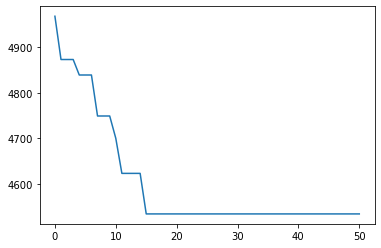

In [12]:
FstarVals = [ g.Fstar  for g in obj.Gens   ]; plt.plot (FstarVals); np.mean(FstarVals)

## reC05 Problem

In [13]:
np.random.seed(12)
obj2 = GAsolver(ProbList[1], N = 50, MaxGen = 40, M = 10, mu = 0.25); obj2

GA Solver
Pop. size :50
# of Generations: 1

In [14]:
tstart = time.process_time_ns()
F2 = obj2.Solve()
tend = time.process_time_ns()
print(f"Executed in {1.e-9*(tend - tstart)} CPU*seconds.")
print(f"Glob. Opt: {ProbList[1].zstar}")
print(f"{100*( F2/ProbList[1].zstar-1):.2f}% larger than Glob. Opt.")

i=10, F*=940.0
i=20, F*=939.0
i=30, F*=939.0
i=40, F*=939.0
Algorithm ended in 40 iteration
F*=939.0
Executed in 3.015625 CPU*seconds.
Glob. Opt: 920
2.07% larger than Glob. Opt.


In [15]:
obj2.solStar

Solution: [4, 2, 0, 5, 11, 8, 12, 10, 7, 6, 1, 9, 3]

947.8780487804878

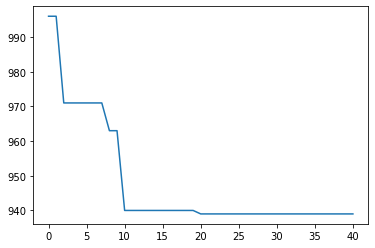

In [16]:
FstarVals2 = [ g.Fstar  for g in obj2.Gens   ]; plt.plot (FstarVals2); np.mean(FstarVals2)

## reC09 Problem

In [17]:
np.random.seed(11)
obj3 = GAsolver(ProbList[2], N = 50, MaxGen = 40, M = 10, mu = 0.25); obj3

GA Solver
Pop. size :50
# of Generations: 1

In [18]:
tstart = time.process_time_ns()
F3 = obj3.Solve()
tend = time.process_time_ns()
print(f"Executed in {1.e-9*(tend - tstart)} CPU*seconds.")
print(f"Glob. Opt: {ProbList[2].zstar}")
print(f"{100*( F3/ProbList[2].zstar-1):.2f}% larger than Glob. Opt.")

i=10, F*=1426.0
i=20, F*=1349.0
i=30, F*=1339.0
i=40, F*=1318.0
Algorithm ended in 40 iteration
F*=1318.0
Executed in 4.296875 CPU*seconds.
Glob. Opt: 1302
1.23% larger than Glob. Opt.


In [19]:
obj3.solStar

Solution: [18, 8, 17, 14, 16, 3, 2, 13, 6, 0, 11, 7, 4, 15, 19, 9, 12, 5, 10, 1]

1383.7073170731708

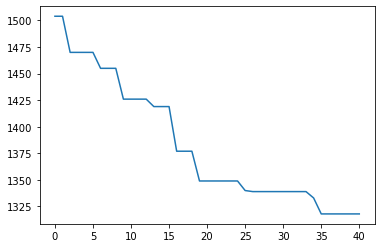

In [20]:
FstarVals3 = [ g.Fstar  for g in obj3.Gens   ]; plt.plot (FstarVals3); np.mean(FstarVals3)